# Tinkering Notebook 3b: Model-free control

In this notebook we will test model-free control. We will implement and use SARSA and Q-learning. If you are interested you can also try to implement Monte Carlo-control, but this method will not work very well on the environments we study in this notebook.

# Table of content
* ### [1. Imports](#sec1)
* ### [2. A note on time limits in OpenAI gym](#sec2)
 * #### [2.1 \*How to handle actual time limits](#sec2_1)
* ### [3. Helper functions](#sec3)
* ### [4. SARSA](#sec4)
 * #### [4.1 SARSA on Example 3.5](#sec4_1)
 * #### [4.2 Example 6.5: Windy Grid World](#sec4_2)
* ### [5. Q-learning](#sec5)
 * #### [5.1 Example 6.6.](#sec5_1)
* ### [6. A note on exploration](#sec6)
* ### [7. \* MountainCar-v0](#sec7)


# 1. Imports <a id="sec1">

In [1]:
import gym
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import gym_gridworld
import gymgrid
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. A note on time limits in OpenAI gym <a id="sec2">

In an episodic MDP, the episode will end when (and only when) a terminal state is reached. In a continuing environment, there are no terminal states so it will never stop.

However, some of the OpenAI gym environments we will study in this notebook stops after a time limit (typically 200 time steps) even if we do not reach a terminal state. It should be noted that this does not mean that the episode has ended in the MDP-sense, since we did not reach a terminal state! 

This is mainly a problem in Monte-Carlo control. Here we first collect the data of a full episode before we do any learning. If the OpenAI gym environment stops due to the time limit, we did not actually get a full episode trajectory! 

In this notebook we will look at SARSA and $Q$-learning. In these cases it is not a problem that the episode terminates prematurely, since we only use 1-step transitions in the updates. 

## 2.1 \*How to handle actual time limits <a id="sec2_1">

In the environments we will study in this notebook it makes sense to treat the time limits in OpenAI gym as artificially stopping the environment before the episode was done.

But there are tasks where the time-limit itself is important. Lets say the task is for a humanoid robot to run as far as possible in 60 s. Optimizing this would lead to different behavior depending on the time: In the beginning it is important for the robot to not fall down, but towards the end of the 60 s it may be a good idea to be more aggressive even if this would mean that the robot falls down after the 60 s are over (throwing itself over the finish line). 

To encode this into an MDP, we would have to include e.g. "time left" in the state. Then any state with "time left = 0" is a terminating state. Without this the state would not have the Markov-property, and a  policy $\pi(a|s)$ could not know if we are in the beginning of the race or if we are close to the end of the 60 s. 

# 3. Helper functions <a id="sec3">

We here define a function `test_policy` that can be used to see the policy we have found in action. It takes an agent and an environment, and runs the agents policy on the environment for one episode while rendering (no learning). It renders the environment and returns the total reward received. If you do not want to render the environment, add `render=False` as an argument. It will run until the episode is done or `max_steps` (default 40) has been taken.

In [2]:
def test_policy(agent, env, wait=0.1, max_steps=40, render=True):
    state = env.reset()
    step = 0
    total_reward = 0
    done = False
    while not done and step<max_steps:
        action = agent.act(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
        step += 1
        
        if render:
            clear_output(wait=True)
            env.render()
            # Show some information
            print("Time step:", step)
            print("Reward:", reward)
            print("Total reward:", total_reward)
            time.sleep(wait)
    env.close()
    return total_reward

# 4. SARSA <a id="sec4">

In this section we will implement and try out SARSA-control.

We first implement the function `train_sarsa` with the arguments
* `agent` - Should be an object with the methods `act` that implements the current policy, and `learn` that is used to update the estimated `Q`.
* `env` - The environment 
* `n_episodes` - The number of episodes we should use to train the agent
* `max_steps` - If the total number of steps taken is larger than `max_steps` we will stop the training even if we have not finished `n_episodes`.

The function also computes an array `steps` that shows the total number of time steps that have been used after each episode, and `total_rewards` that gives the total reward for each episode.

**Task:** Read the code, and compare it with the pseudo-code for SARSA seen in the slides of Lecture 3. Make sure that you understand it.

In [3]:
def train_sarsa(agent, env, n_episodes, max_steps=50000):
    step = 0
    steps = np.zeros(n_episodes) # Steps after each episode
    total_rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        state = env.reset()
        action = agent.act(state)
        rewards=0
        done = False
        while not done:
            state_next, reward, done, info = env.step(action)
            action_next = agent.act(state_next)
            agent.learn(state, action, reward, state_next, action_next)
            state = state_next
            action = action_next
            step += 1
            rewards += reward
            
            if step>max_steps:
                return total_rewards, steps
            
        steps[i] = step
        total_rewards[i] = rewards
    return total_rewards, steps

We next define the class `SARSA` that implements the agent. 

**Task:** 
1. Implement a policy in `act` that is $\varepsilon$-greedy w.r.t `self.Q`. ($\varepsilon$ = `self.epsilon`)

2. Implement the SARSA-update of $Q$ in `learn`.

In [4]:
class SARSA():
    def __init__(self, n_states, n_actions, gamma, alpha, epsilon):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = np.zeros((n_states, n_actions))
        
    def act(self, state):
        # You can use np.random.choice(self.n_actions) to get a random action
        # Implement epsilon-greedy policy
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            Q_list = self.Q[state, :]
            maxQ = np.max(Q_list)
            action_list = np.where(Q_list == maxQ)[0] 
            action = np.random.choice(action_list)
        else:
            action = np.random.choice(self.n_actions)
        return action
            
    def learn(self, s, a, r, s_next, a_next):
        # Implement the TD(0) update of Q (see equation (6.7) in textbook)
        predict_Q = self.Q[s, a]
        target_Q = r + self.gamma * self.Q[s_next, a_next] 
        self.Q[s, a] += self.alpha * (target_Q - predict_Q)


## 4.1 SARSA on Example 3.5 <a id="sec4_1">

Here we will try SARSA on the `GridWorld-5x5-AB-v0`. The environment is described in Example 3.5 in the textbook, and the optimal policy is shown in Figure 3.5. This is a continuing environment, so there is no terminal state. However, as discussed above, the OpenAI Gym environment will still stop after 200 time steps due to a time limit.

**Note on exploration:** When a relatively good policy is found, the agent will keep moving from $A'$ to $A$, with the occasional random action due to the $\varepsilon$-greedy policy. Hence, we will mainly learn about these states. However, when we reset the environment we restart at a random state, and thus resetting the environment helps with exploration. Here we will reset the environment after 200 time steps.

In this environment the discount is $\gamma = 0.9$. Lets try to the step size $\alpha = 0.1$ and exploration rate $\varepsilon = 0.2$.

In [5]:
env = gym.make('GridWorld-5x5-AB-v0') # the same as in Example 3.5
agent = SARSA(env.observation_space.n, env.action_space.n, gamma=0.9, alpha=0.1, epsilon=0.1)

We now train train the agent. 

**Note:** If you run the cell below again without resetting the agent, you will continue from your already estimated $Q$. That is, running the cell below two times effectively doubles the number of time steps.

In [6]:
n_resets = 1000 # Train with n_resets * 200 time steps
rewards, _ = train_sarsa(agent, env, n_resets, max_steps=n_resets*200) 

We next plot the total reward for each 200 times steps (before we reset). 
This should hopefully show that the total reward may start at a very small level, but that it will increase as the agent learns more.

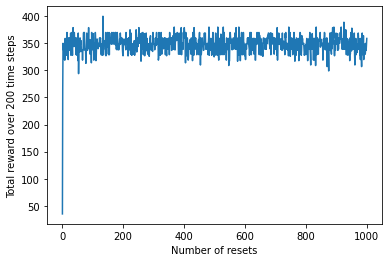

In [7]:
plt.plot(range(1, n_resets+1), rewards)
plt.xlabel("Number of resets")
plt.ylabel("Total reward over 200 time steps");

We next test to see how the policy works in practice. Note that we are still using the $\varepsilon$-greedy policy in `agent`, so it will choose a random action with probability $\varepsilon$. 

The main reason for using an $\varepsilon$-greedy policy is to ensure that the agent explores while it trains. Here we want to evaluate the policy that the agent has learned, and it thus makes sense to set the exploration to zero ($\varepsilon = 0$) and hence use the greedy policy w.r.t the estimated $Q$. (However, if you will continue to train after this, you should add exploration again)

**Task:** Test your policy both with the $\varepsilon$-greedy policy you trained your policy with, and the greedy policy ($\varepsilon = 0$).

In [8]:
#agent.epsilon = 0
test_policy(agent, env, max_steps=40)
#agent.epsilon = 0.2

  (Up)
FAFBF
FFFFF
FFFbF
FFFFF
FaFFF
Time step: 40
Reward: 0.0
Total reward: 70.0


70.0

If you only trained with $100 \times 200$ time steps, it is common that SARSA find a greedy policy that sometimes ends up going from b to B over and over again. This is not optimal, since going from $a$ to $A$ gives a higher reward. Try to increase the number of time steps you use in training to see if you can get a better result!

We can also visualize the greedy policy w.r.t $Q$ with the following function.

In [9]:
def render_greedy_policy(Q):
    # Prints an illustration of the greedy policy with respect to Q
    n_states = Q.shape[0]
    greedy = np.full(n_states, 'L') 
    for s in range(n_states):
            a = np.argmax(Q[s,:])
            if a == 0:
                greedy[s] = 'L'
            elif a == 1:
                greedy[s] = 'D'
            elif a == 2:
                greedy[s] = 'R'
            elif a == 3:
                greedy[s] = 'U'

    print(greedy.reshape(5,5))

In [10]:
render_greedy_policy(agent.Q)

[['R' 'D' 'D' 'D' 'L']
 ['R' 'U' 'L' 'L' 'L']
 ['R' 'U' 'U' 'U' 'L']
 ['R' 'U' 'U' 'L' 'L']
 ['R' 'U' 'L' 'L' 'U']]


**Task:** Compare the greedy policy found by SARSA with the optimal policy found in Figure 3.5 in the textbook. If the policy you have found is not optimal, then train it some more!

## 4.2 Example 6.5: Windy Grid World <a id="sec4_2">

In this section we will try out Example 6.5 in the textbook. To do so, we use the `gymgrid` package. 
    
In this environment we have a $7 \times 10$ grid, with a starting point and a goal. It is a windy grid world, since in some of the columns the agent will get pushed up when it takes an action. See Example 6.5 for a detailed explanation. 
    
Lets look at the state and action spaces of the environment.

In [11]:
env = gym.make('windy-grid-world-v0')
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)

State space:  Discrete(70)
Action space:  Discrete(8)


2022-04-22 10:46:52.134 Python[33640:344987] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/org.python.python.savedState


* **State space**: The 70 states corresponds to the 70 different possible positions of the agent.
* **Action space**: This environment implements the version in Exercise 6.9. The actions corresponds to <br>0 - West<br>
1 - East<br>
2 - North<br>
3 - South<br>
4 - North west<br>
5 - North east<br>
6 - South west<br>
7 - South east<br>
In order to implement Example 6.5 you should only allow the agent to use the first four actions. To try out Exercise 6.9 you allow the agent to use all actions. This means that we should use four possible actions in SARSA to get Example 6.5.

* **Reward**: The agent gets a reward of -1 for each action, and we consider this to be an undiscounted task ($\gamma = 1$), so the objective of the agent is just to reach the goal in as few steps as possible. For Example 6.5 (four actions) the optimal policy uses 15 steps. This environment do not have any time-limits implemented, so it will continue until the terminal state (goal) is reached!

We will first try out the agent using the exact same setting as in Example 6.5 ($\alpha = 0.5$ and $\varepsilon=0.1$), training the agent using 170 episodes. However note that, due to the use of random actions, you will not get exactly the same result as in Example 6.5 every time. If you are unlucky, you may even get a policy that have a hard time reaching the goal.
Note that we set the number of actions to 4, to ensure that the agent only use West, East, North or South.

In [12]:
agent = SARSA(env.observation_space.n, 4, gamma=1, alpha=0.5, epsilon=0.1)

Next we train the agent. 

**Note:** If you rerun the cell below, without resetting (creating a new) agent, you will start from the Q-table you previously trained. That is, you will effectively double the number of training episodes.

In [13]:
n_episodes=170
rewards, steps = train_sarsa(agent, env, n_episodes); 

To get a plot similar to the one in Example 6.5, you can run:

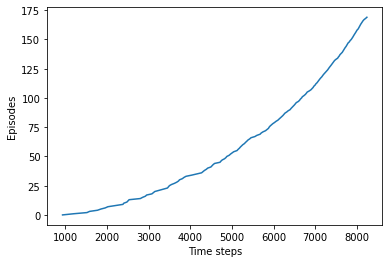

In [14]:
plt.plot(steps, range(steps.shape[0]))
plt.xlabel('Time steps')
plt.ylabel('Episodes');

To see the policy in action we can use `test_policy`. 

As in the previous example, `test_policy` will use the $\varepsilon$-greedy policy. To also see the greedy policy w.r.t $Q$ in action, first set `agent.epsilon = 0`.

**Task:** Run the $\varepsilon$-greedy you trained with a few times, and then try the greedy policy ($\varepsilon = 0$). If your policy did not succeed, try to train it again (or just increase the number of training episodes).

In [15]:
#agent.epsilon = 0
test_policy(agent, env, max_steps=40)
#agent.epsilon = 0.1

Time step: 21
Reward: -1
Total reward: -21


-21

### Task:

Do Exercise 6.9 (i.e. let the agent use all possible 8 actions instead of just the first 4). Before you try this out, look at the example and see if you can find a better policy when all actions are allowed. How many steps are needed with all actions available? Then try to train an agent using SARSA to find this policy.

# 5. Q-learning <a id="sec5">

We now implement $Q$-learning. We first define the function `train_q`. It is very similar to `train_sarsa`, but for $Q$-learning we do not need `action_next` when we update the $Q$-function.

**Task:** Look through the code, and compare it with the pseudo-code in the slides of Lecture 3.

In [3]:
def train_q(agent, env, n_episodes, max_steps=50000):
    step = 0
    steps = np.zeros(n_episodes) # Steps after each episode
    total_rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        state = env.reset()
        rewards=0
        done = False
        while not done:
            action = agent.act(state)
            state_next, reward, done, info = env.step(action)
            agent.learn(state, action, reward, state_next)
            state = state_next
            step += 1
            rewards += reward
            
            if step>max_steps:
                return steps, rewards
            
        steps[i] = step
        total_rewards[i] = rewards
    return total_rewards, steps

Next we define the class `QAgent`. Note that the goal of $Q$-learning is to estimate the optimal $Q$-function while running a different behavioral policy. Here we implement the behavioral policy ($\varepsilon$-greedy w.r.t to current estimate of $Q$) in `act`.

**Task:** 
1. Implement the behavior policy in `act`. That is $\varepsilon$-greedy w.r.t `self.Q`. ($\varepsilon$ = `self.epsilon`)

2. Implement the Q-learning update in `learn`.

In [4]:
class QAgent():
    def __init__(self, n_states, n_actions, gamma, alpha, epsilon):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((n_states, n_actions))
        
    def act(self, state):
        # Implement the self.epsilon-greedy policy
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            Q_list = self.Q[state, :]
            maxQ = np.max(Q_list)
            action_list = np.where(Q_list == maxQ)[0] 
            action = np.random.choice(action_list)
        else:
            action = np.random.choice(self.n_actions)
        return action
            
    def learn(self, s, a, r, s_next):
        # Implement the Q-learning update
        s_next_list = self.Q[s_next, :]
        self.Q[s, a] += self.alpha * (r + self.gamma * np.max(s_next_list) - self.Q[s, a])

## 5.1 Example 6.6. <a id="sec5_1">

We will now try out $Q$-learning and SARSA on the environment described in Example 6.6. Here the agent should go from start to goal, while avoiding the cliff region. If the agent steps into the cliff region it gets a reward of -100 and is returned to the start.
        
Lets look at the environment:

In [18]:
env = gym.make('cliff-v0')
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)

State space:  Discrete(48)
Action space:  Discrete(4)


* **State space:** One state for each of the possible agent positions.
* **Action space:** The actions are defined as in the windy grid world. That is <br>
0 - West<br>
1 - East<br>
2 - North<br>
3 - South<br>
* **Reward:** -1 for each step, except when the agent enters the cliff region resulting in a -100 reward.

We will train one agent using $Q$-learning and one agent using SARSA.

Both uses $\gamma = 1$, $\alpha = 0.3$ and $\varepsilon = 0.1$.

In [19]:
agentQ = QAgent(env.observation_space.n, env.action_space.n, gamma=1, alpha=0.3, epsilon=0.1)
agentSARSA = SARSA(env.observation_space.n, env.action_space.n, gamma=1, alpha=0.3, epsilon=0.1)

Train both agent for e.g. 1000 episodes

In [20]:
train_q(agentQ, env, n_episodes=1000)
train_sarsa(agentSARSA, env, n_episodes=1000);

You can now test to run your two policies. 

**Note:** In both cases you use the `act`-method that is implemented with an $\varepsilon$-greedy policy. To use the greedy policy w.r.t $Q$ we first have to set $\varepsilon = 0$. 

**Task:** Try to run both with $\varepsilon$-greedy and greedy policies ($\varepsilon = 0$).

In [21]:
#agentQ.epsilon = 0
total_reward = test_policy(agentQ, env, max_steps=100)
#agentQ.epsilon = 0.1

Time step: 17
Reward: 0
Total reward: -16


In [22]:
#agentSARSA.epsilon = 0
total_reward = test_policy(agentSARSA, env, max_steps=100)
#agentSARSA.epsilon = 0.1

Time step: 19
Reward: 0
Total reward: -18


We can see that the two policies behaves quite differently. SARSA tries to learn the best $\varepsilon$-soft policy while $Q$-learning tries to learn the optimal $q_*$. 

In this example, the $Q$-learning algorithm will thus try to take as short path to the goal as possible. However, the SARSA-algorithm looks at $\varepsilon$-soft policies, and thus also has to take into account that there is a non-zero probability that a non-greedy action is taken. Since the cost of moving into the cliff region is so large, it will take a safer path to ensure that a non-optimal action will not lead into the cliff.

**Task:** 
Below is a code that will run both the policies learned from $Q$-learning and SARSA 1000 times. It then prints the mean reward. 

Try to run the code both using the $\varepsilon$-greedy policies and the greedy policy ($\varepsilon = 0$). We can see that if the policy is $\varepsilon$-soft then the $Q$-learning version does worse because it more often moves into the cliff region. However, when we set $\varepsilon=0$ then $Q$-learning is best because it takes the shortest path.

In [23]:
n_episodes = 1000
reward_Q = np.zeros(n_episodes)
reward_SARSA = np.zeros(n_episodes)
#agentQ.epsilon = 0
#agentSARSA.epsilon = 0
for k in range(n_episodes):
    reward_Q[k] = test_policy(agentQ, env, max_steps=100, render=False)
    reward_SARSA[k] = test_policy(agentSARSA, env, max_steps=100, render=False)

#agentQ.epsilon = 0.1
#agentSARSA.epsilon = 0.1
    
print("Mean reward Q: ", np.mean(reward_Q))
print("Mean reward SARSA: ", np.mean(reward_SARSA))

Mean reward Q:  -48.942
Mean reward SARSA:  -20.164


# 6. A note on exploration <a id="sec6">

In this notebook we have used $\varepsilon$-greedy policies to ensure that we always continue to explore during training. However, there are other ways to get exploration and we will discuss them later in the course. 

An easy way to at get at least temporary exploration would be to initialize your $Q$-function with large values compared to the best possible return (except for terminating states which should be initialized to 0). 

This would mean that state/action pairs that we have never seen before will have a large estimated value, and therefor the agent is encouraged to visit them. 

For example, in the Windy GridWorld, the rewards are always negative. We initialize $Q$ with zeros. When we now are in a state and try an action, we will update the $Q$-value for this state/action pair to something negative. Next time we come to this state, the actions we have not tried yet all have estimated value 0, so they will look better! 

**Task:** Try to train both `windy-grid-world-v0` and `GridWorld-5x5-AB-v0` with $\varepsilon = 0$. Use the discussion above to explain the results. 

# 7. \* MountainCar-v0 <a id="sec7">

So far in the course we have looked at environment with a finite number of states and actions. Hence we can represent the $Q$-function as a matrix where each element corresponds to a state/action-pair. 

If the state (or action) space is continuous (infinitely many states) this is not possible. We will start looking in to these types of problems in Lecture 6. 

However, already now we can mention one simple trick that can sometimes work in these cases - namely discretization of the state space. 

As an example we look at the `MountainCar-v0` environment studied in Tinkering Notebook 1. Here the state contains two elements: the position and velocity of the car. 

**Idea:** We divide the state space into a number of discrete states as in the image below.
<center><img src="./grid.png"></center>
Hence, every position/velocity pair that ends up in tile 4 is considered to be in state 4. An implication of this is that we learn the same $Q$-value for any position/velocity pair in tile 4 etc. Hence, the $Q$-values are now only approximations of the true $Q$-values, but if the grid is fine enough we may still be able to learn a good policy.

The function `toDiscreteState` can be used to divide the 2-dimensional state space of MountainCar into a tiles[0]  ×  tiles[1] grid. Given a 2-dimensional state of MountainCar it will return an integer representing the discretized state. It will be enough to use a  30×30  grid, i.e., 900 states. (It may also work well with fewer states).

In [24]:
def toDiscreteState(state, tiles=np.array([30,30])):
    max_range = np.array([1.2, 0.07]) #  -1.2 <= pos <= 1.2, -0.07 <= vel <= 0.07
    
    state_tile = np.floor((tiles)*(state+max_range)/(2*max_range))
    
    if state_tile[0] >= tiles[0]:
        state_tile[0] = tiles[0]-1
    if state_tile[1] >= tiles[1]:
        state_tile[1] = tiles[1]-1
        
    return int(state_tile[0]+state_tile[1]*tiles[0])

The function `train_car` below can be used to train a SARSA-agent using the discretized states. It is implemented just as `train_sarsa` but uses the discreteized states instead of the true continuous states.

We also define `test_car` that is similar to `test_policy` above, but uses `toDiscreteState`.

In [25]:
def train_car(agent, env, n_episodes):
    total_rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        state = env.reset()
        state = toDiscreteState(state) # To discrete state!
        action = agent.act(state)
        rewards=0
        done = False
        while not done:
            state_next, reward, done, info = env.step(action)
            state_next = toDiscreteState(state_next) # To discrete state!
            action_next = agent.act(state_next)
            agent.learn(state, action, reward, state_next, action_next)
            state = state_next
            action = action_next
            rewards += reward
            
        total_rewards[i] = rewards
        
        if i % 100 == 0:
            clear_output(wait=True)
            print("Episode", i)
            
    clear_output(wait=True)
    print("Done")
    return total_rewards

def test_car(agent, env, wait=0.01, render=True): 
    state = toDiscreteState(env.reset())
    step = 0
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, info = env.step(action)
        state = toDiscreteState(state)
        total_reward += reward
        step += 1
        
        if render:
            clear_output(wait=True)
            env.render()
            # Show some information
            print("Time step:", step)
            print("Reward:", reward)
            print("Total reward:", total_reward)
            time.sleep(wait)
    env.close()
    return total_reward

We use the SARSA-agent implemented previously. We use discount $\gamma = 0.99$.

In [32]:
env = gym.make('MountainCar-v0')
agent = SARSA(30*30, 3, gamma=0.99, alpha=0.1, epsilon=0.1)

This is a relatively hard problem to solve. The reward signal gives $-1$ for each step until the flag is reached. Hence, before the agent has reached the flag the first time all actions will look equally bad. For this reason you will probably not see any improvement at all for about 1000 episodes.  

The environment has a time limit of 200 time steps. So if an episode goes on for longer than 200 time steps, it will be ended prematurely.

Try to train it for 2000 episodes to start with (this will take some time). To find a policy that is near optimal, you will probably have to increase the number of episodes to at least 10 000. 

In [27]:
n_episodes = 2000
rewards = train_car(agent, env, n_episodes)

Done


We now plot the total rewards given after each episode. Note that, since the episode stops if the episode goes on for more than 200 time steps, to worst possible total reward we can get is -200.

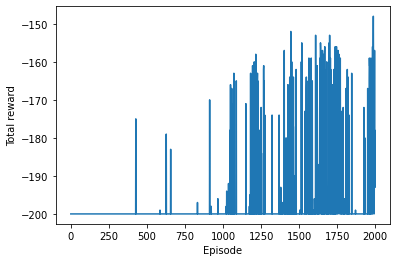

In [28]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward');

Finally we test to see how the car behaves in practice. If it does not manage to reach the flag every time you run it, try to train it for more episodes. 

*Note:* If you re-run the code cell with `train_car` without resetting the agent, it will continue to train from your current estimated `Q`-function instead of restarting from scratch.

In [29]:
agent.epsilon = 0
total_reward = test_car(agent, env)
agent.epsilon = 0.1

Time step: 200
Reward: -1.0
Total reward: -200.0


**Note on exploration:** Here we again have a case where we initialize $Q$ to zero, but all rewards are negative. Hence, this will aid with the exploration, since $Q$ for actions not tested before will always look better than for actions we have tested previously. 

## Assignment 2 Question 4

Use Q-learning to find the optimal policy for the Taxi-v3 environment. This is an undiscounted
problem, i.e. $\gamma$ = 1. You can use $\alpha$ = 0.1, $\varepsilon$ = 0.1 and train on at least 10 000 episodes.
Doing like this you should get an estimated Q-function such that (at least in most states) the greedy
policy w.r.t Q is optimal. In the quizz the question will be e.g.:

“Give the optimal action in state s = 410” for a few different states. So be sure that you have code ready to answer these types of questions. Since there is a risk that the Q-learning will find a policy that is not optimal in every possible state, you pass this part even if you only give the correct answer in 80% of the states asked for.

Remember: When you have finished training your policy, you should use the greedy policy to answer the questions. If you use a $\varepsilon$-greedy with $\varepsilon$ > 0 there is a chance that you return an action that is not greedy w.r.t Q.

Tips: When you are done training your agent, it is also fun to use test policy from Tinkering Notebook 3 to see your agent in action. This can also give you a feeling for if the agent seems to behave in an optimal way.

In [11]:
def train_q(agent, env, n_episodes, max_steps=50000):
    step = 0
    steps = np.zeros(n_episodes) # Steps after each episode
    total_rewards = np.zeros(n_episodes)
    actions = {}
    for i in range(n_episodes):
        state = env.reset()
        rewards=0
        done = False
        while not done:
            action = agent.act(state)
            actions[state] = action
            state_next, reward, done, info = env.step(action)
            agent.learn(state, action, reward, state_next)
            state = state_next
            step += 1
            rewards += reward
            
            if step>max_steps:
                return rewards, steps, actions
                
        #actions[i] = action    
        steps[i] = step
        total_rewards[i] = rewards
    return total_rewards, steps, actions

In [13]:
class QAgent():
    def __init__(self, n_states, n_actions, gamma, alpha, epsilon):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((n_states, n_actions))
        
    def act(self, state):
        # Implement the self.epsilon-greedy policy
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            Q_list = self.Q[state, :]
            maxQ = np.max(Q_list)
            action_list = np.where(Q_list == maxQ)[0] 
            action = np.random.choice(action_list)
        else:
            action = np.random.choice(self.n_actions)
        return action
            
    def learn(self, s, a, r, s_next):
        # Implement the Q-learning update
        s_next_list = self.Q[s_next, :]
        self.Q[s, a] += self.alpha * (r + self.gamma * np.max(s_next_list) - self.Q[s, a])

In [14]:
env = gym.make("Taxi-v3")
env.render()
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State space:  Discrete(500)
Action space:  Discrete(6)


In [8]:
action_names = [
    'South (↓)',
    'North (↑)',
    'East (→)',
    'West (←)',
    'Pickup',
    'Drop off',
]

In [22]:
agent = QAgent(env.observation_space.n, env.action_space.n, gamma=1, alpha=0.1, epsilon=0.1)
n_episodes = 10000
print("begin \n")
total_rewards, steps, actions= train_q(agent, env, n_episodes)
print(actions[186], actions[227], actions[23], actions[376], actions[422])

begin 

1 2 0 1 1


In [10]:
total_reward = test_policy(agent, env, max_steps=100)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Time step: 100
Reward: -1
Total reward: -163
